# SVD with TensorFlow

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

import numpy as np
import scipy.spatial as sp
import tensorflow as tf

import matrices.loading as matload
import resources.dataset as rsdata

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rcParams["figure.figsize"] = (8,8)
mpl.rcParams['figure.dpi']= 200
mpl.rcParams['image.cmap'] = 'jet'
cmap = cm.get_cmap('jet')
cmap.set_bad('w') # Print bads as white

sess = tf.Session() # tensorflow

In [3]:
data_path = "resources/aminer/v1" # 629814 documents

In [4]:
# Load sparse matrix with jaccard similarities.
matrix_tmp = matload.load_matrix_jaccard_sim(data_path)

n = matrix_tmp.shape[0]

matrix_jaccard = tf.constant(matrix_tmp, name='matrix_jaccard')

# dice
matrix_dice = tf.constant(np.divide(np.multiply(2,matrix_tmp), np.add(matrix_tmp, 1)), name='matrix_dice')

# Jaccard disimilarity
matrix_jaccard_dis =  tf.constant(np.subtract(1, matrix_tmp), name='matrix_jaccard_dis')

del matrix_tmp

# Load sparse matrix with word2vec similarities.
matrix_tmp = matload.load_matrix_word2vec_sim(data_path)

matrix_word2vec = tf.constant(matrix_tmp, name='matrix_word2vec')

del matrix_tmp

pltmask =  np.tri(n, k=-1) # Mask to plot upper triangular matrix.   

# Load document ids in the Same order than the matrices
indexdocs = matload.get_document_ids(data_path)

print("\nMatrices.")
print(matrix_jaccard)
print(matrix_jaccard_dis)
print(matrix_dice)
print(matrix_word2vec)

Loading saved matrix ...
Loading saved matrix ...

Matrices.
Tensor("matrix_jaccard:0", shape=(998, 998), dtype=float32)
Tensor("matrix_jaccard_dis:0", shape=(998, 998), dtype=float32)
Tensor("matrix_dice:0", shape=(998, 998), dtype=float32)
Tensor("matrix_word2vec:0", shape=(998, 998), dtype=float32)


In [5]:
# Tensors 
M = tf.Variable(tf.zeros((n,n),  dtype=tf.float32), dtype=tf.float32, name='M') 
s, u, v = tf.svd(M) #SVD

# ns = n
ns = 1 # one singular value

# UDV' matrix reconstruction with ns singular values
M_ = tf.matmul(u[:,:ns], tf.matmul(tf.diag(s[:ns]), v[:,:ns], adjoint_b=True)) 
# M_ = tf.matmul(u[:,:ns], v[:,:ns], adjoint_b=True) # UV'

sess.run(tf.global_variables_initializer())  

print("Tensors for SVD. \nM_ is the reconstruction of the matrix M with %d singular value(s)." % (ns))

Tensors for SVD. 
M_ is the reconstruction of the matrix M with 1 singular value(s).


In [6]:
op = M.assign(matrix_jaccard)
sess.run(op)
jaccard_approximation = sess.run(M_) # Reconstruction of the matrix M
jaccard_singular_values = sess.run(s) # Singular values  

op = M.assign(matrix_jaccard_dis)
sess.run(op)
jaccarddis_approximation = sess.run(M_)
jaccarddis_singular_values = sess.run(s)

op = M.assign(matrix_dice)
sess.run(op)
dice_approximation = sess.run(M_)
dice_singular_values = sess.run(s)

op = M.assign(matrix_word2vec)
sess.run(op)
word2vec_approximation = sess.run(M_)
word2vec_singular_values = sess.run(s)

print("Matrix reconstructions using %d singular value(s)" % (ns))

Matrix reconstructions using 1 singular value(s)


In [7]:
print("SVD: Largest singular values:\n \
        \nJaccard sim. s0 = %f \nJaccard dis. s0 = %f \nDice sim. s0 = %f \
        \nwod2vec sim. s0 = %f" % (jaccard_singular_values[0], jaccarddis_singular_values[0], 
      dice_singular_values[0], word2vec_singular_values[0]))

SVD: Largest singular values:
         
Jaccard sim. s0 = 9.587548 
Jaccard dis. s0 = 990.752136 
Dice sim. s0 = 16.390749         
wod2vec sim. s0 = 101.521500


### Plotting the matrix approximations

In the following graphs $s_0$ is not plotted because it is too large in the cases of wod2vec and jaccard disimilarities. 

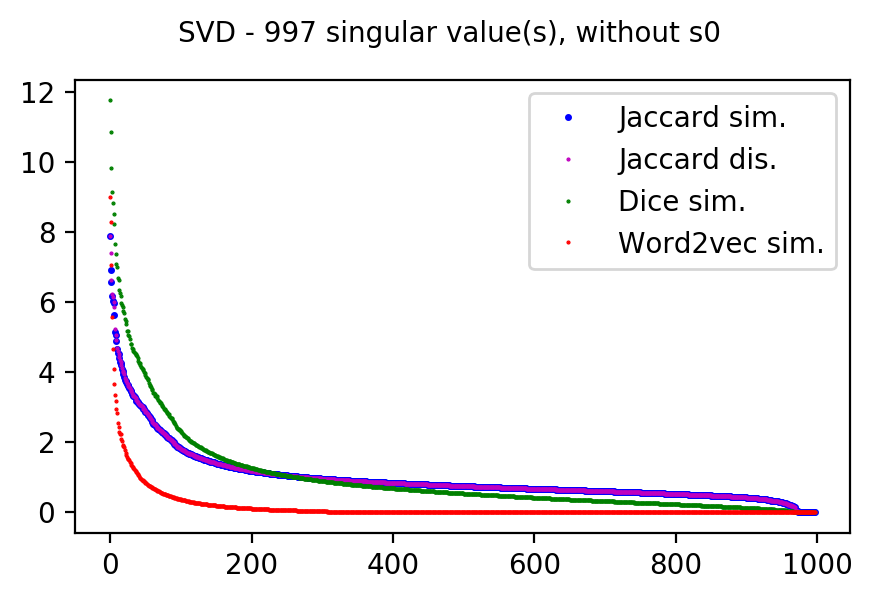

In [8]:
fig = plt.figure(figsize=(5, 3))
fig.suptitle("SVD - %d singular value(s), without s0" % (n - 1), fontsize=10)

# Plotting singular values. s0 is too large for word2vec
ax1 = plt.subplot(1, 1, 1)
ax1.plot(jaccard_singular_values[1:], 'b.', mew=1.0, ms=3.0, label="Jaccard sim.")
ax1.plot(jaccarddis_singular_values[1:], 'm.', mew=1.0, ms=1.0, label="Jaccard dis.")
ax1.plot(dice_singular_values[1:], 'g.', mew=1.0, ms=1.0, label="Dice sim.")
ax1.plot(word2vec_singular_values[1:], 'r.', mew=1.0, ms=1.0, label="Word2vec sim.")

plt.legend()
plt.show()

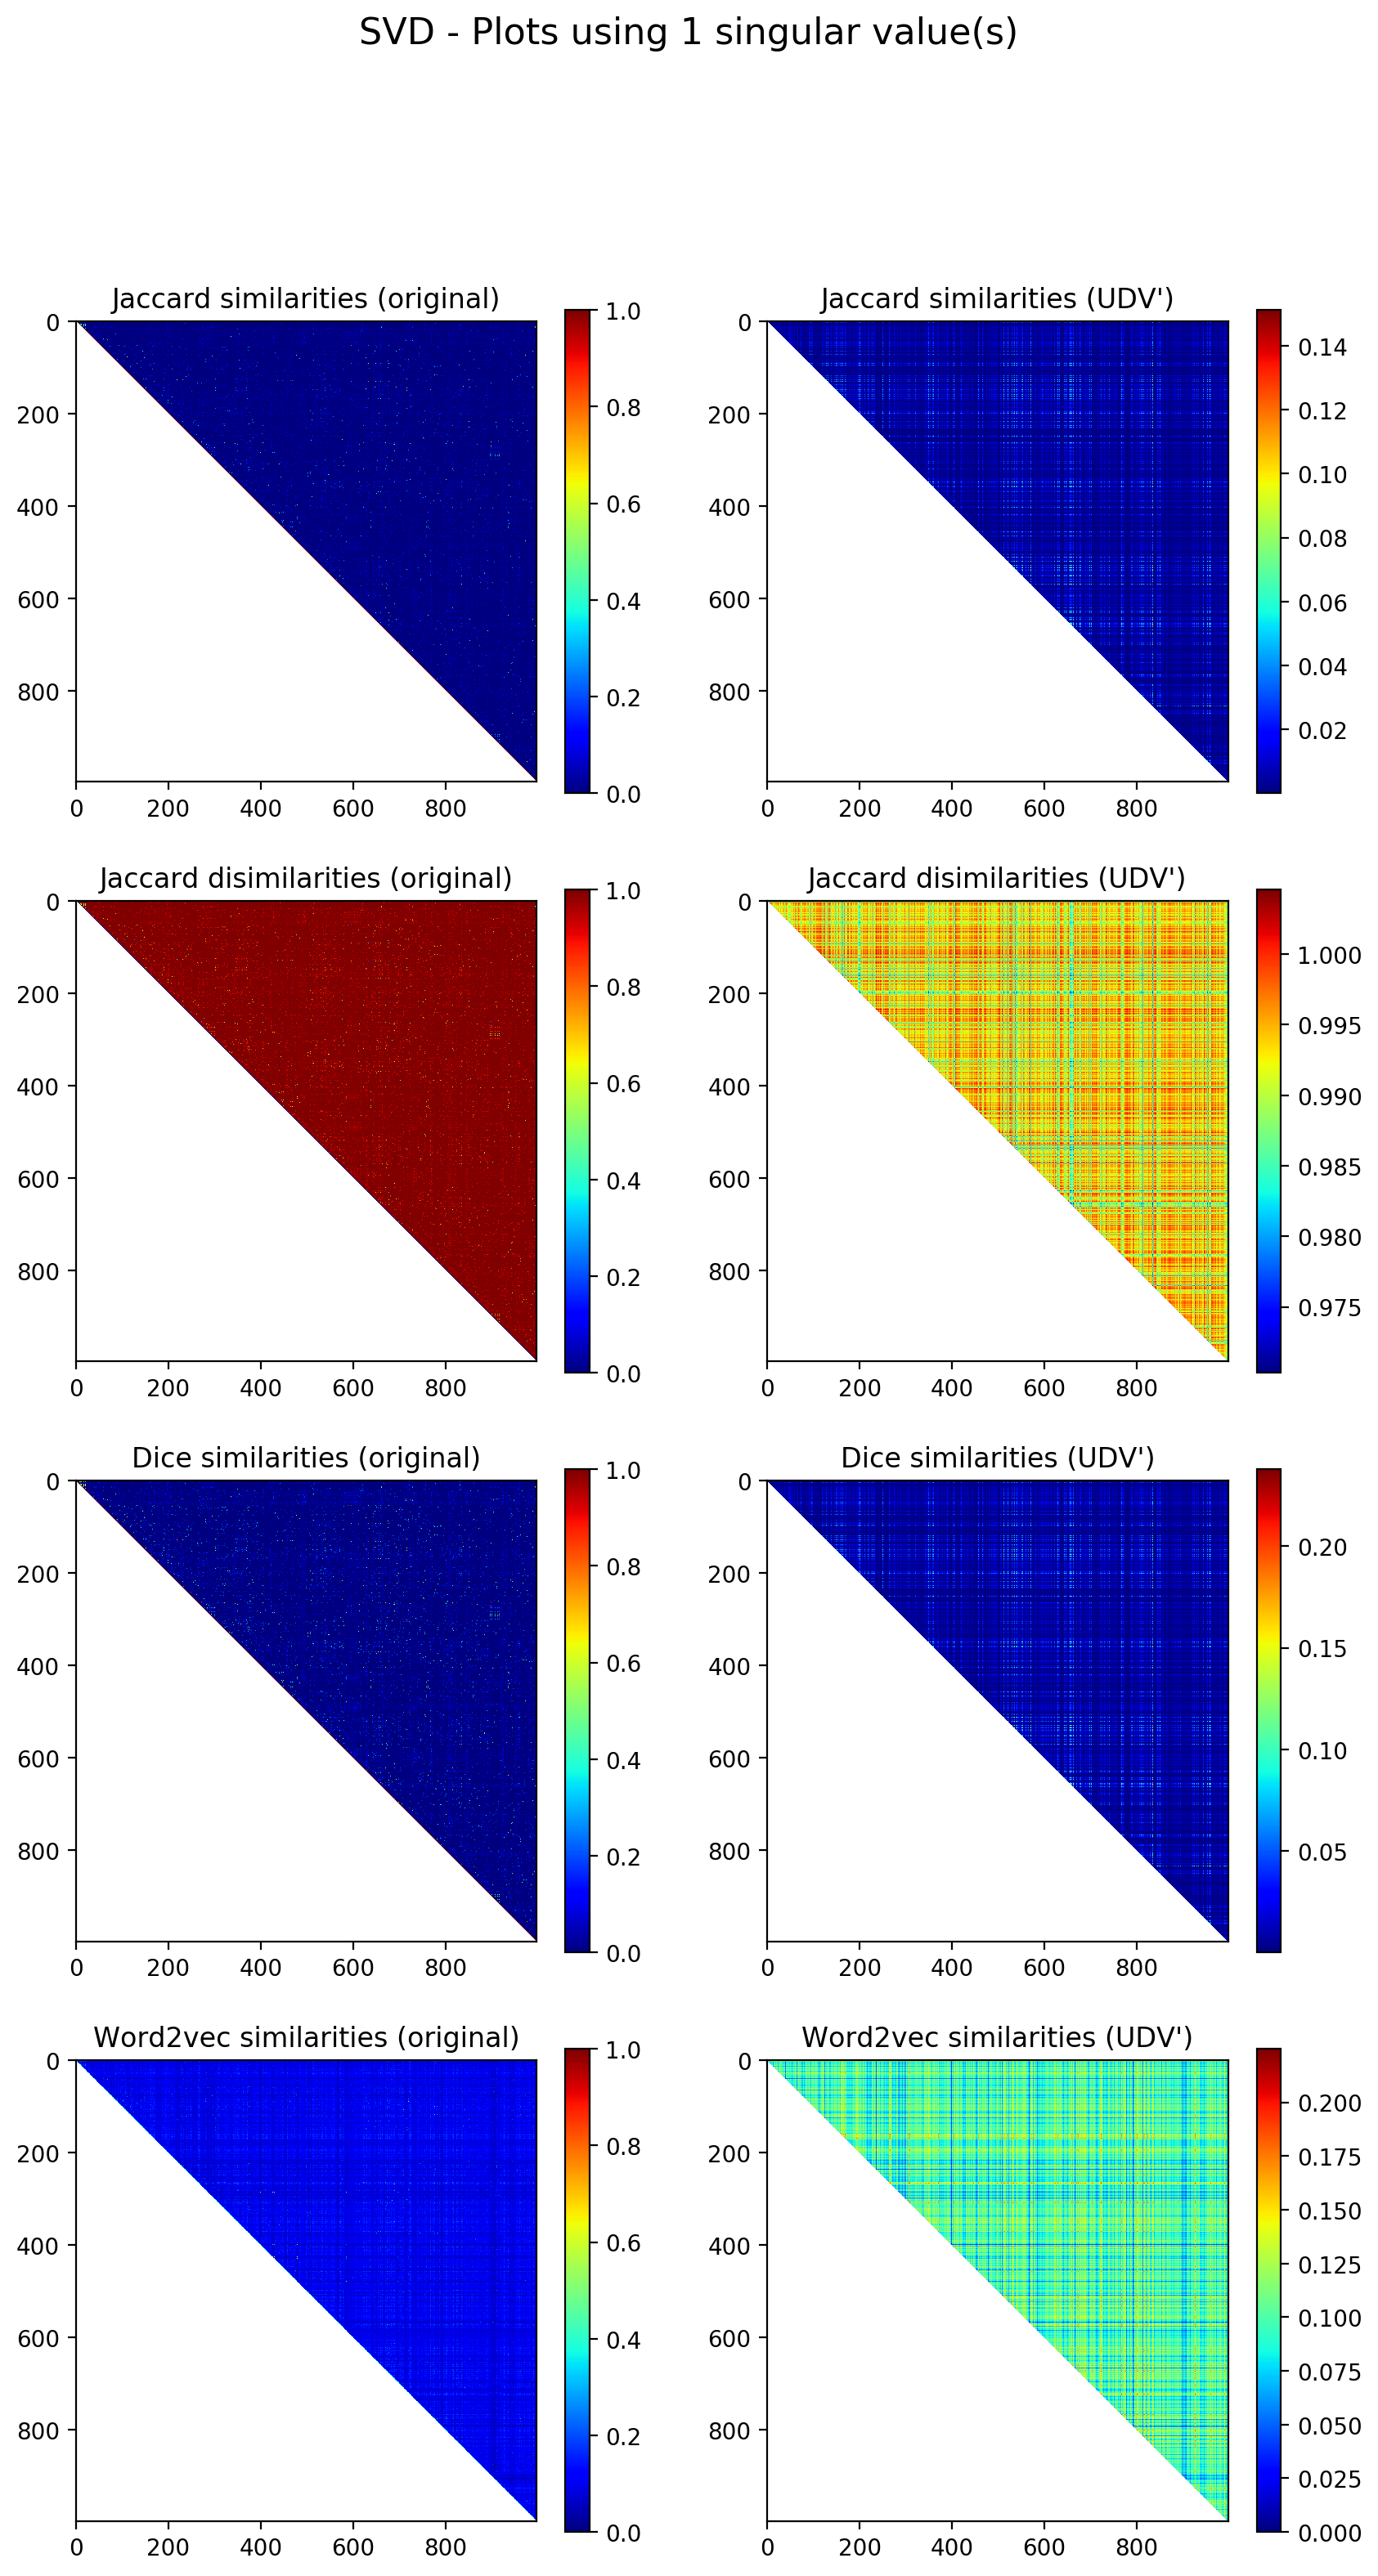

In [9]:
fig = plt.figure(figsize=(10,18))
fig.suptitle("SVD - Plots using %d singular value(s)" % (ns), fontsize=16)

ax_jaccard = plt.subplot(4, 2, 1)
ax_jaccard.set_title("Jaccard similarities (original)")
im_jaccard = ax_jaccard.imshow(np.ma.array(sess.run(matrix_jaccard), mask=pltmask))
plt.colorbar(im_jaccard)
# Reconstructed matrix using the largest singular value.
ax_jaccard_ = plt.subplot(4, 2, 2)
ax_jaccard_.set_title("Jaccard similarities (UDV')")
im_jaccard_ = ax_jaccard_.imshow(np.ma.array(jaccard_approximation, mask=pltmask))

plt.colorbar(im_jaccard_)

ax_jaccard_dis = plt.subplot(4, 2, 3)
ax_jaccard_dis.set_title("Jaccard disimilarities (original)")
im_jaccarddis = ax_jaccard_dis.imshow(np.ma.array(sess.run(matrix_jaccard_dis), mask=pltmask))
plt.colorbar(im_jaccarddis)
# Reconstructed matrix using the largest singular value.
ax_jaccard_dis_ = plt.subplot(4, 2, 4)
ax_jaccard_dis_.set_title("Jaccard disimilarities (UDV')")
im_jaccarddis_ = ax_jaccard_dis_.imshow(np.ma.array(jaccarddis_approximation, mask=pltmask))
plt.colorbar(im_jaccarddis_)

ax_dice = plt.subplot(4, 2, 5)
ax_dice.set_title("Dice similarities (original)")
im_dice = ax_dice.imshow(np.ma.array(sess.run(matrix_dice), mask=pltmask))
plt.colorbar(im_dice)
# Reconstructed matrix using the largest singular value.
ax_dice_ = plt.subplot(4, 2, 6)
ax_dice_.set_title("Dice similarities (UDV')")
im_dice_ = ax_dice_.imshow(np.ma.array(dice_approximation, mask=pltmask))
plt.colorbar(im_dice_)

ax_word2vec = plt.subplot(4, 2, 7)
ax_word2vec.set_title("Word2vec similarities (original)")
im_word2vec = ax_word2vec.imshow(np.ma.array(sess.run(matrix_word2vec), mask=pltmask))
plt.colorbar(im_word2vec)
# Reconstructed matrix using the largest singular value.
ax_word2vec_ = plt.subplot(4, 2, 8)
ax_word2vec_.set_title("Word2vec similarities (UDV')")
im_word2vec_ = ax_word2vec_.imshow(np.ma.array(word2vec_approximation, mask=pltmask))
plt.colorbar(im_word2vec_)

plt.show()

### Ordering matrices for better visualization 

From the matrix approximations with SVD is calculated the mean for each column. Later, the means are used to order the matrices. 

In [10]:
# Means of jaccard similarities using the reconstructed matrix 
jaccard_similarity_mean = tf.reduce_mean(jaccard_approximation, 1)
# Ordered indices by mean of similarities in the approximation
jaccard_indices = sess.run(jaccard_similarity_mean).argsort()[::-1]

# Means of word2vec similarities using the reconstructed matrix 
word2vec_similarity_mean = tf.reduce_mean(word2vec_approximation, 1)
# Ordered indices by mean of similarities in the approximation
word2vec_indices = sess.run(word2vec_similarity_mean).argsort()[::-1]

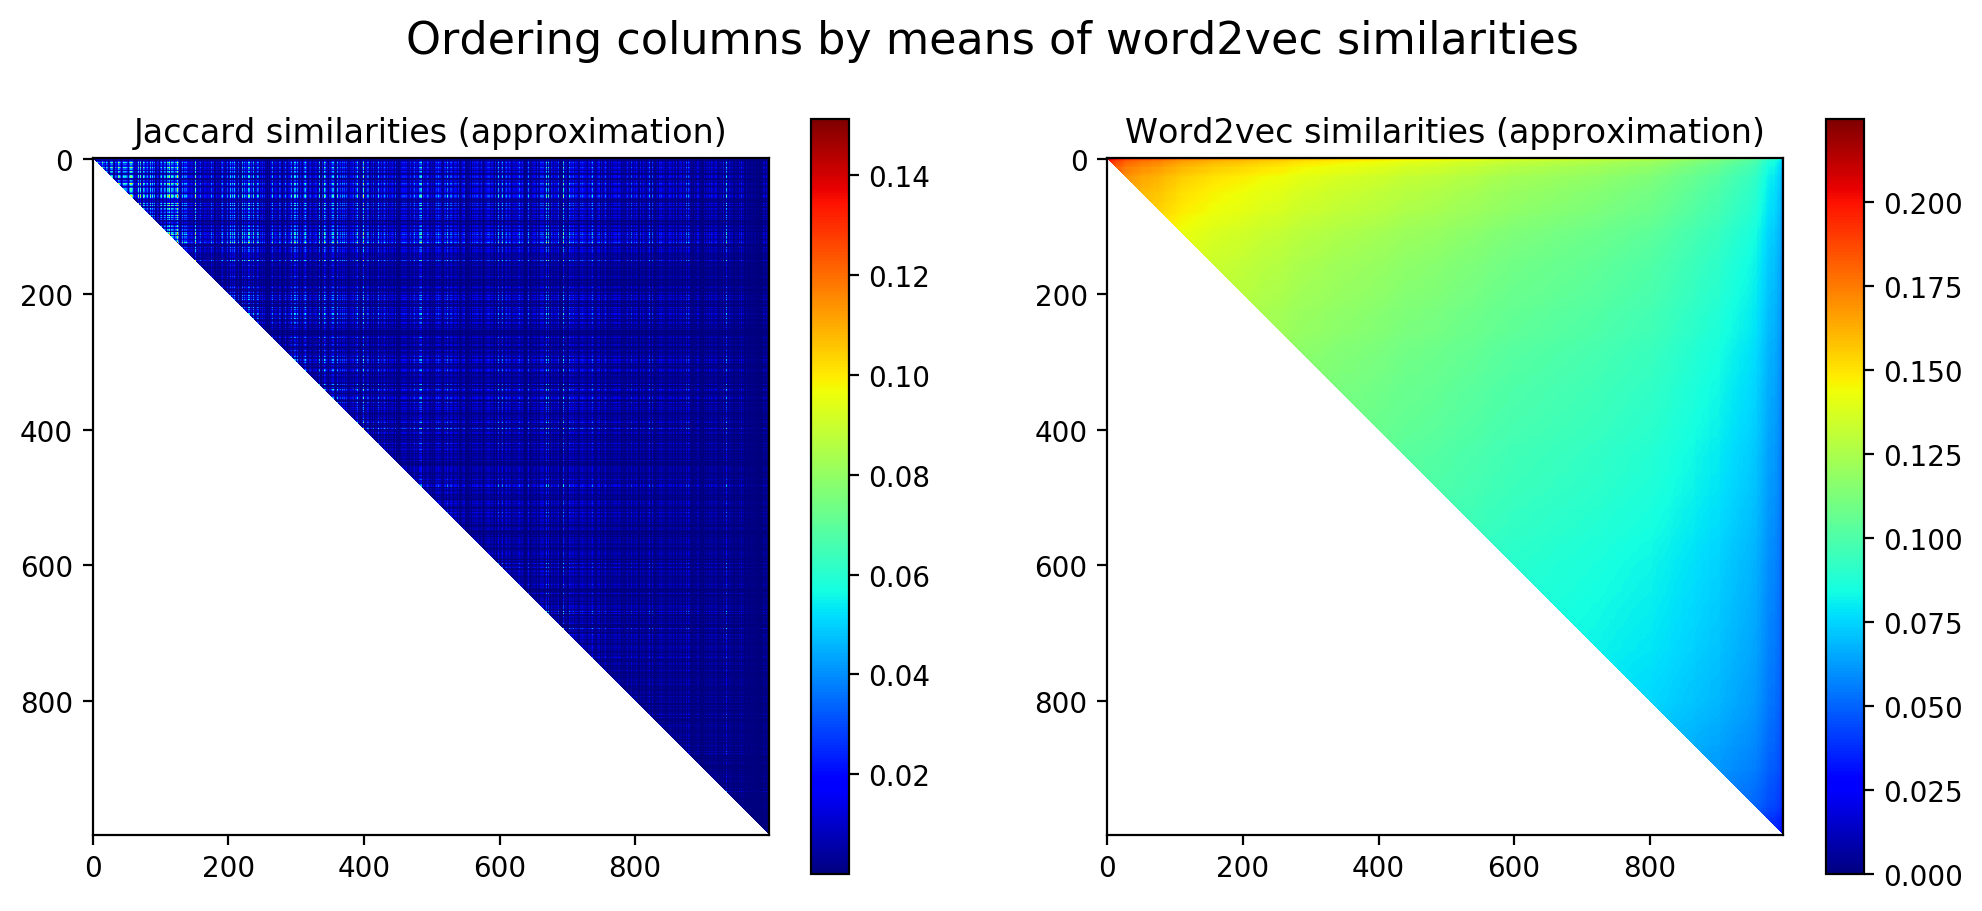

In [11]:
fig = plt.figure(figsize=(12,5))
fig.suptitle("Ordering columns by means of word2vec similarities", fontsize=16)

ax_jaccard = plt.subplot(1, 2, 1)
ax_jaccard.set_title("Jaccard similarities (approximation)")
im_jaccard_arranged = ax_jaccard.imshow(np.ma.array(
    jaccard_approximation[:,word2vec_indices][word2vec_indices,:], mask=pltmask))
plt.colorbar(im_jaccard_arranged)

ax_word2vec = plt.subplot(1, 2, 2)
ax_word2vec.set_title("Word2vec similarities (approximation)")
im_word2vec_arranged = ax_word2vec.imshow(np.ma.array(
    word2vec_approximation[:,word2vec_indices][word2vec_indices,:], mask=pltmask))
plt.colorbar(im_word2vec_arranged)

plt.show()

A mask is generated from jaccard similarities, given $s_{ij} \in S$ with S being the matrix, the mask is the matrix K.

\begin{equation}
  k_{ij}=\left\{
  \begin{array}{@{}ll@{}}
    1, & \text{if}\ s_{ij}=0 \\
    0, & \text{otherwise}
  \end{array}\right.
\end{equation} 

Each similarity equal to zero with jaccard means that between two documents there is not a correspondence in words.

In [12]:
# Mask
jaccard_mask = sess.run(tf.where( tf.equal(matrix_jaccard, 0.0), 
                                 tf.ones(matrix_jaccard.get_shape()), tf.zeros(matrix_jaccard.get_shape())))

jaccard_mask_ordered = jaccard_mask[:,word2vec_indices][word2vec_indices,:]

with sess.as_default():
    print("Jaccard matrix\n", matrix_jaccard[:3,:3].eval())
    print("\nJaccard mask\n", jaccard_mask[:3,:3])

Jaccard matrix
 [[1.         0.14285715 0.        ]
 [0.14285715 1.         0.        ]
 [0.         0.         1.        ]]

Jaccard mask
 [[0. 0. 1.]
 [0. 0. 1.]
 [1. 1. 0.]]


The mask is aplyed over word2vec by multiplying each element in the matrix $s_{ij}k_{ij}$ (not matrix multiplication).

In [13]:
# Mask over word2vec
jaccardmask_word2vecapprox = sess.run(tf.convert_to_tensor(jaccard_mask)*word2vec_approximation)
jaccardmask_word2vecapprox_ordered = jaccardmask_word2vecapprox[:,word2vec_indices][word2vec_indices,:]

with sess.as_default():
    # The resulting word2vec matrix keeps only values of similitaties 
    # where jaccard has a similarity of zero
    print("Small example with the mask.")
    print("\nword2vec (approx.)\n", word2vec_approximation[:3,:3])
    print("\nMaskered word2vec\n", jaccardmask_word2vecapprox[:3,:3])

Small example with the mask.

word2vec (approx.)
 [[0.07846789 0.06433386 0.10137664]
 [0.06433419 0.05274599 0.0831166 ]
 [0.10137682 0.08311632 0.13097385]]

Maskered word2vec
 [[0.         0.         0.10137664]
 [0.         0.         0.0831166 ]
 [0.10137682 0.08311632 0.        ]]


This mask is only used to illustrate that similar documents don't necessarily have co-occurrence of words. 

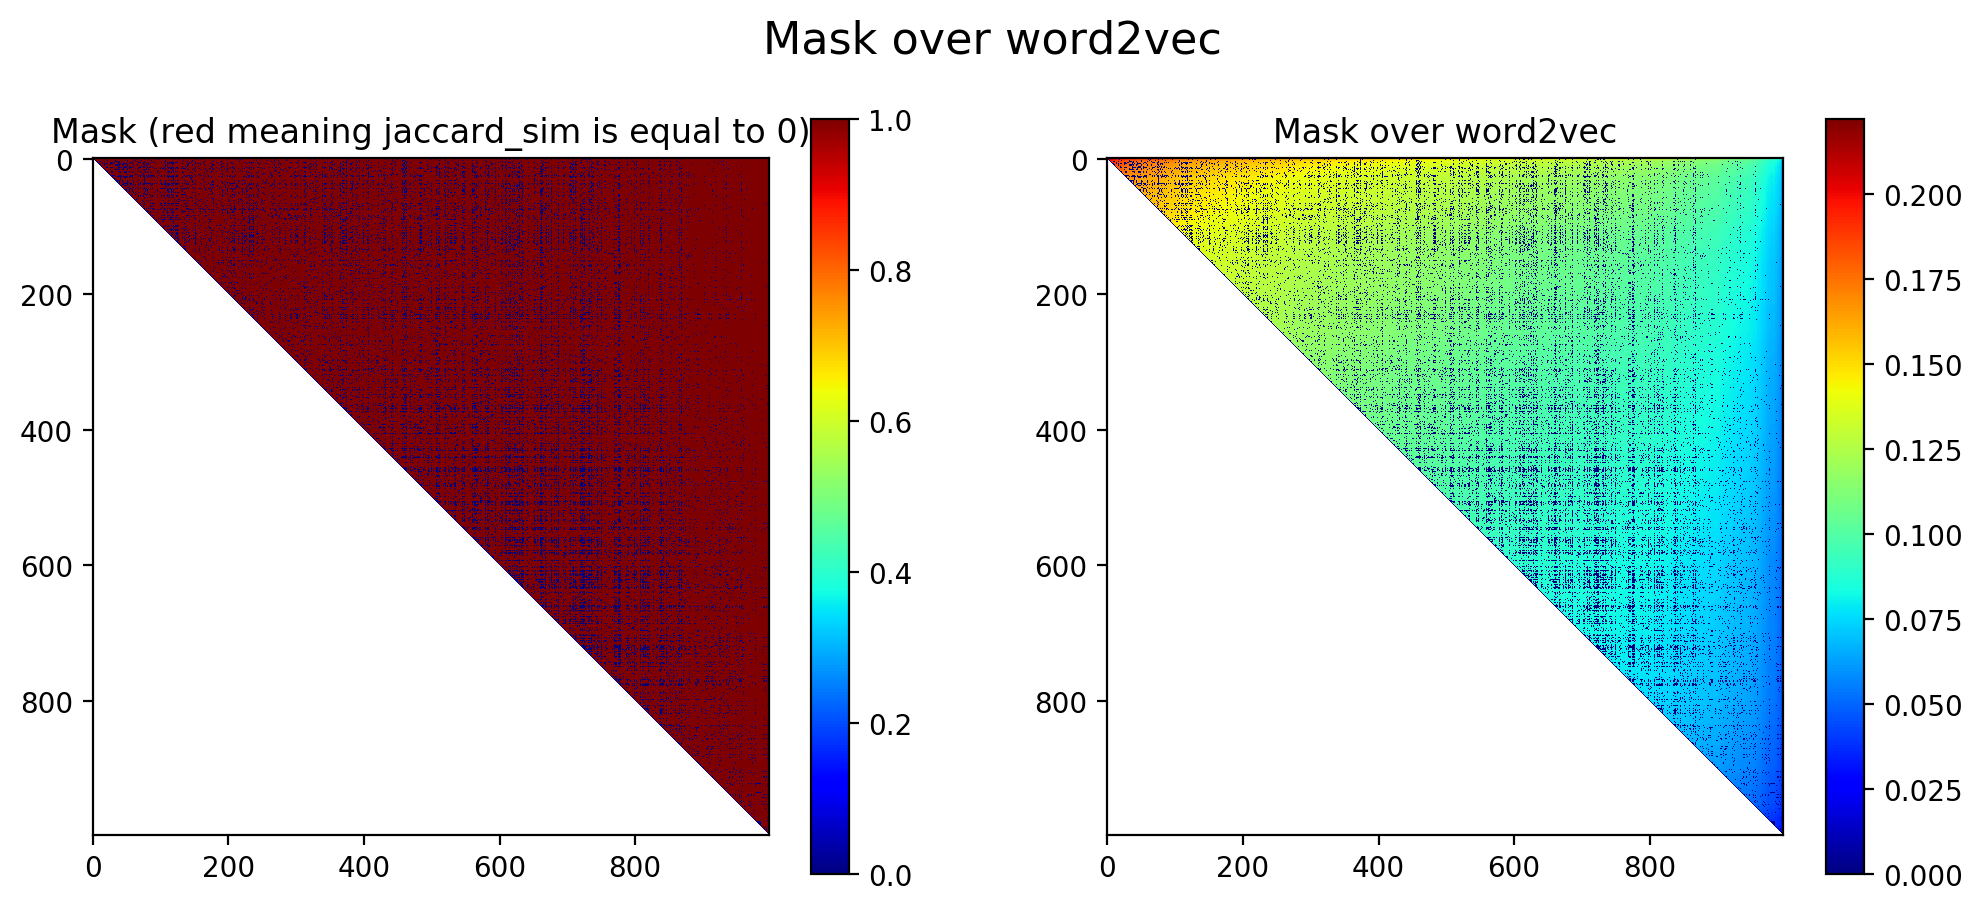

In [14]:
fig = plt.figure(figsize=(12,5))
fig.suptitle("Mask over word2vec", fontsize=16)

ax_mask = plt.subplot(1, 2, 1)
ax_mask.set_title("Mask (red meaning jaccard_sim is equal to 0)")
im_mask = ax_mask.imshow(
                np.ma.array(
                    jaccard_mask_ordered, 
                    mask=pltmask
                )
            )
plt.colorbar(im_mask)

ax_jm_wa = plt.subplot(1, 2, 2)
ax_jm_wa.set_title("Mask over word2vec")
im_jm_wa = ax_jm_wa.imshow(
                np.ma.array(
                    jaccardmask_word2vecapprox_ordered, 
                    mask=pltmask
                )
            )
plt.colorbar(im_jm_wa)
plt.show()

In [15]:
size_submatrix = 200
subpltmask = pltmask[:size_submatrix,:size_submatrix]

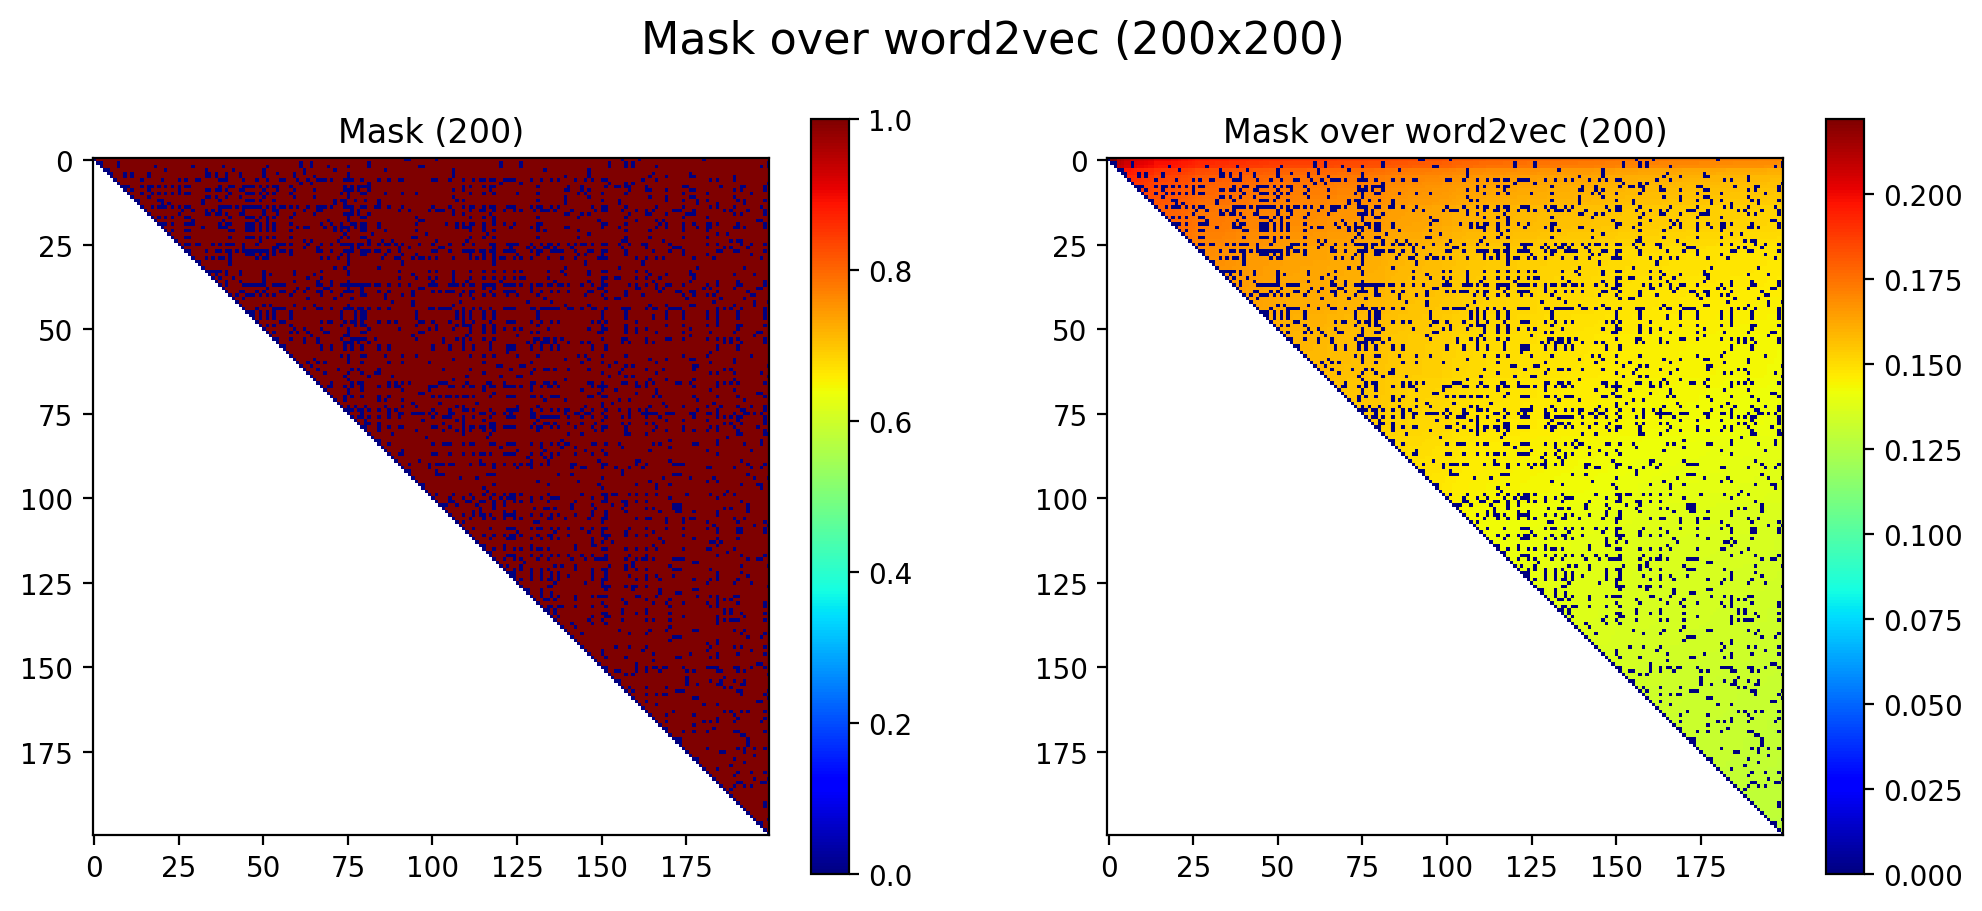

In [16]:
fig = plt.figure(figsize=(12,5))
fig.suptitle("Mask over word2vec (%dx%d)" % (size_submatrix, size_submatrix) , fontsize=16)

ax_mask_seg = plt.subplot(1, 2, 1)
ax_mask_seg.set_title("Mask (%d)" % size_submatrix )
im_mask_seg = ax_mask_seg.imshow(
                np.ma.array(
                    jaccard_mask_ordered[:size_submatrix,:size_submatrix], 
                    mask=subpltmask
                )
            )
plt.colorbar(im_mask_seg)

ax_jm_wa_seg = plt.subplot(1, 2, 2)
ax_jm_wa_seg.set_title("Mask over word2vec (%d)" % size_submatrix )
im_jm_wa_seg = ax_jm_wa_seg.imshow(
                np.ma.array(
                    jaccardmask_word2vecapprox_ordered[:size_submatrix,:size_submatrix], 
                    mask=subpltmask
                )
            )
plt.colorbar(im_jm_wa_seg)

plt.show()

In [17]:

def freq_zero_jaccard_sim_triu(JM):
    N_JM_i, N_JM_j = JM.shape
    zero_sim = 0
    gt_zero = 0
    total_values = 0
    for i in range(0, N_JM_i):
        j = i+1
        while j < N_JM_j:
            total_values += 1
            if JM[i,j] == 1:
                zero_sim += 1
            else:
                gt_zero += 1
            j += 1
    return zero_sim/total_values, gt_zero/total_values

def freq_zero_jaccard_sim_full(JM):
    N_JM_i, N_JM_j = JM.shape
    zero_sim = 0
    gt_zero = 0
    total_values = 0
    for i in range(0, N_JM_i):
        j = 0
        while j < N_JM_j:
            total_values += 1
            if JM[i,j] == 1:
                zero_sim += 1
            else:
                gt_zero += 1
            j += 1
    return zero_sim/total_values, gt_zero/total_values

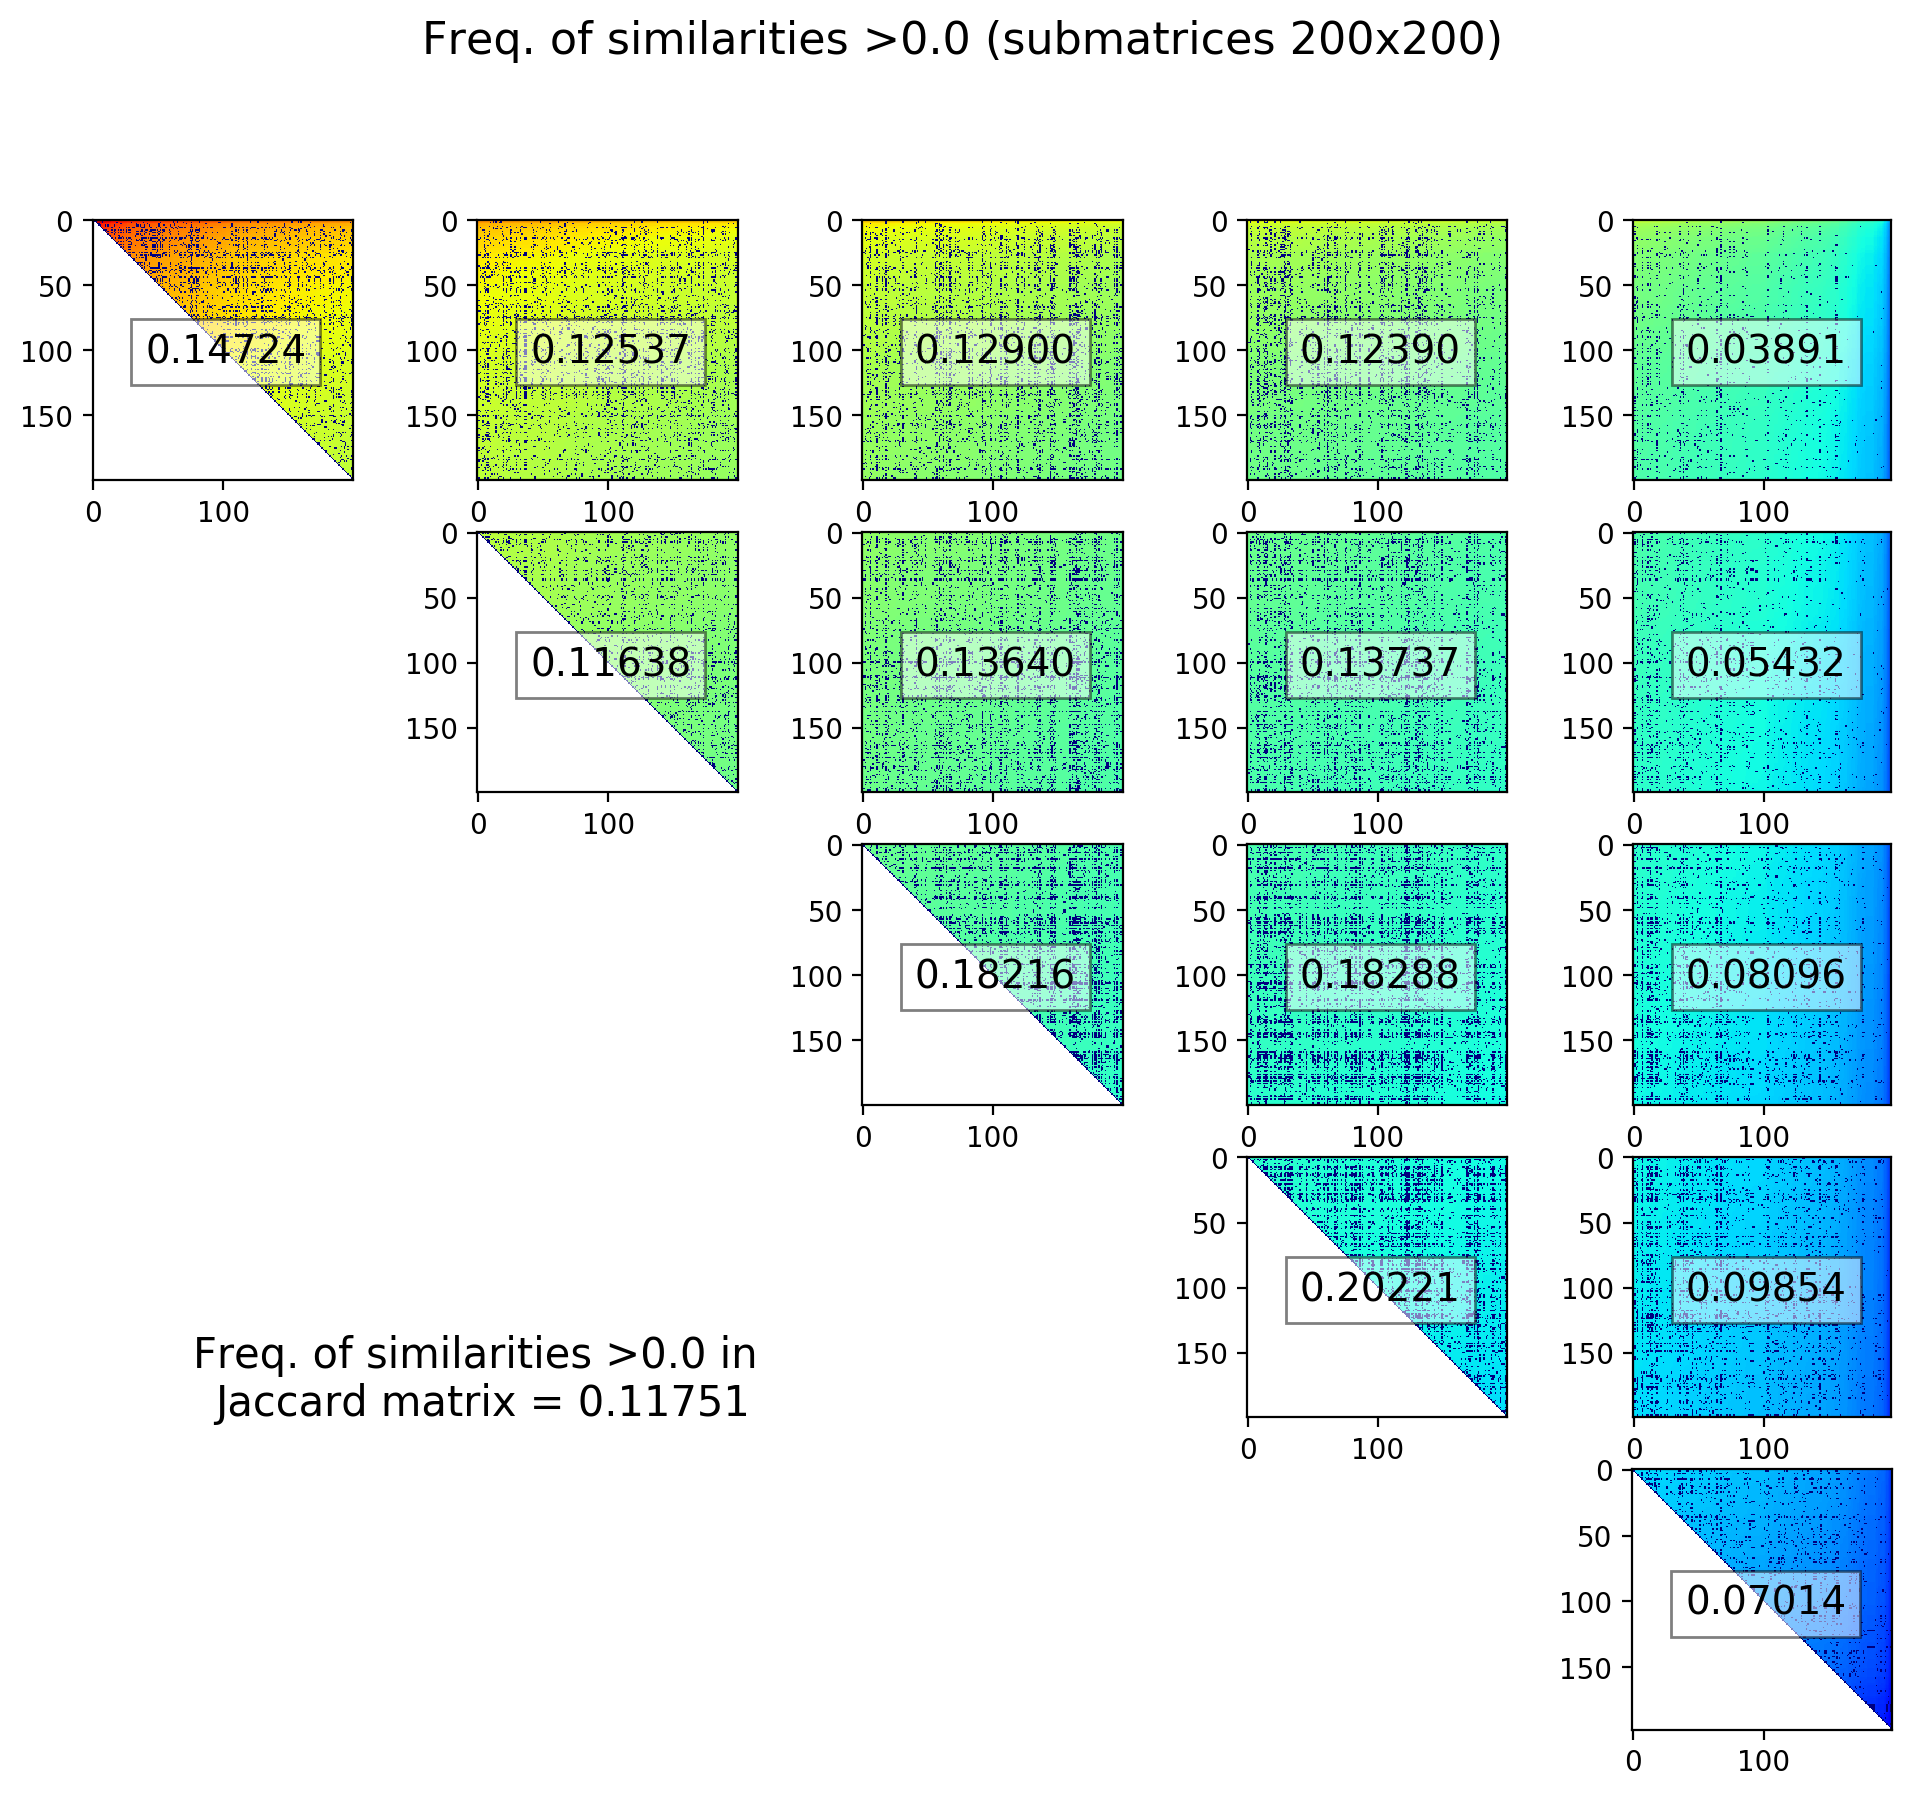

In [18]:
fig = plt.figure(figsize=(12,10))

n_subms = int(np.ceil(n/size_submatrix).tolist())
center_size_submatrix = size_submatrix/2
vmax=jaccardmask_word2vecapprox_ordered.max()

zero_sim_freq_full, gt_zero_sim_freq_full = freq_zero_jaccard_sim_triu(jaccard_mask_ordered)

fig.suptitle("Freq. of similarities >0.0 (submatrices %dx%d)" % (size_submatrix, size_submatrix), fontsize=16)

for i_subimage in range(0, n_subms):
    m_istart = i_subimage * size_submatrix
    m_iend = (i_subimage + 1) * size_submatrix
    j_subimage = i_subimage
    while j_subimage < n_subms:   
        m_jstart = j_subimage * size_submatrix
        m_jend = (j_subimage + 1) * size_submatrix
        
        submatrix_tmp = jaccardmask_word2vecapprox_ordered[m_istart:m_iend,m_jstart:m_jend]
        submask_tmp = jaccard_mask_ordered[m_istart:m_iend, m_jstart:m_jend]
        zero_sim_freq, gt_zero_sim_freq = freq_zero_jaccard_sim_triu(submask_tmp) if i_subimage == j_subimage else freq_zero_jaccard_sim_full(submask_tmp) 
        
        plt.subplot(n_subms, n_subms, j_subimage + (i_subimage*n_subms) + 1)     
        plt.text(center_size_submatrix - 60, 
                        center_size_submatrix + 10, 
                        '%.5f' % (gt_zero_sim_freq), 
                        fontsize=14, 
                        color='black',
                        bbox={'facecolor':'white', 'alpha':0.5, 'pad':5}
                   )
        
        im = plt.imshow(
                    np.ma.array(
                        submatrix_tmp, 
                        mask = subpltmask[:submatrix_tmp.shape[0],:submatrix_tmp.shape[0]] if i_subimage == j_subimage else None
                    ),
                    vmin=0.0, vmax=vmax
                )
        j_subimage += 1 

fig.text(0.3, 0.3, 'Freq. of similarities >0.0 in \nJaccard matrix = %.5f' % gt_zero_sim_freq_full, ha='center', va='center', size=15)

plt.show()

# Data samples 

## Document ids orderedby word2vec means.

In [19]:
indexdocs_ordered_word2vec = np.array(indexdocs)[word2vec_indices]
n_documents = 200 
ix_data_sample = rsdata.cur_indexed_sample(data_path)

## Bag-of-words of the first n documents

In [20]:
print("First %d documents in the ordered graph\n" % n_documents)
# print(indexdocs_ordered_word2vec[:n_documents])
for idoc in indexdocs_ordered_word2vec[:n_documents]:
    result = rsdata.find_indexdoc(ix_data_sample, idoc)
    for r in result:
        print(r['indexdoc'], r['bag_of_words'])

First 200 documents in the ordered graph

index97023 algol simulation 68
index288618 partitioning algorithm
index201353 partitioning algorithm logic
index111566 graphical spatial applications audio
index74743 metaphors spatial spatialization user interfaces
index234054 graphs interfaces computer human
index525961 approach integrated dynamic manufacturing systems modeling
index171162 partitioning nonparametric algorithm multiclass
index256988 analysis workstations design multimedia subsystem
index486928 principles interfaces design human computer
index189817 analysis networks multilayer neural optimization
index541978 interfaces computer human cognitive complexity
index81445 data echnical warehousing architecture
index467054 ecl risc mips implementation cmos architecture
index363994 approach performance testing integrated analysis systems parallel
index186267 based software system module rigi construction interface model evolution specifications integration
index148329 human interfaces 

index450715 simple computing external geodesic polygon diameter
index79691 retrieval keywords efficient text full algorithm multiple
index564977 based object component conceptual oriented development modeling
index282344 clock zero routing multiple systems skew synchronous
index161864 theoretical aspects reasoning expert knowledge database about systems
index569863 based object monitoring management systems distributed
index290636 bayesian networks inference advanced
index355379 based constraint maintenance propagation algorithm value
index75006 computing visualization limited large environments terrains resource
index371160 dynamics cfd engineering large material scale modelling fluid processes computational utilising granular
index183035 assertions approach machines state integrated verification systems distributed modeling
index472232 system kerberos level security high architectures
index440973 data analysis visual viii exploration
index300303 object techniques large scale modellin

In [21]:
# print(indexdocs_ordered_word2vec[:n_documents])
for idoc in indexdocs_ordered_word2vec[:n_documents]:
    result = rsdata.find_indexdoc(ix_data_sample, idoc)
    for r in result:
        print(r['indexdoc'], r['bag_of_words'])

index97023 algol simulation 68
index288618 partitioning algorithm
index201353 partitioning algorithm logic
index111566 graphical spatial applications audio
index74743 metaphors spatial spatialization user interfaces
index234054 graphs interfaces computer human
index525961 approach integrated dynamic manufacturing systems modeling
index171162 partitioning nonparametric algorithm multiclass
index256988 analysis workstations design multimedia subsystem
index486928 principles interfaces design human computer
index189817 analysis networks multilayer neural optimization
index541978 interfaces computer human cognitive complexity
index81445 data echnical warehousing architecture
index467054 ecl risc mips implementation cmos architecture
index363994 approach performance testing integrated analysis systems parallel
index186267 based software system module rigi construction interface model evolution specifications integration
index148329 human interfaces design issues computer
index278255 analysi

index472232 system kerberos level security high architectures
index440973 data analysis visual viii exploration
index300303 object techniques large scale modelling model symbolic manipulation oriented simplification continuous systems
index146919 applications system principle semilinear problems maximum elliptic
index298005 using image based system rendering model interactive geometric acceleration massive mmr
index257076 agent multi constraint concurrent processes systems
index470853 retrieval system advanced text full information
index172863 u.s flexible industry manufacturing systems assessment competitive
index542970 techniques efficient fourier digital processing signal transform convolution
index253398 risc programmer examples computer mips architecture view
index4747 design mcitp 2005 database microsoft solutions sql server developer
index564606 software improvement measuring process evaluation cost integrating assessment quality
index295243 techniques parasitics efficient chip 

## Bag-of-words of the last n documents

In [22]:
print("\n\nLast %d documents in the ordered graph\n" % n_documents)
# print(indexdocs_ordered_word2vec[-n_documents:])
for idoc in indexdocs_ordered_word2vec[-n_documents:]:
    result = rsdata.find_indexdoc(ix_data_sample, idoc)
    for r in result:
        print(r['bag_of_words'])



Last 200 documents in the ordered graph

motion accords paper worker most into confirm workers drive first qualities work therefore manufacturing motions improve system assembly everywhere accelerometers fix but products instruction diagonal context fundamental generally some cases materials dividing cell sensors using parts step case control former line violation distinguishable there discuss quality confirmed schemes very little terrestrial grasp production also each magnetism tracing detect actual arm show later procedure appearance manuals only example design violated important however processes recognizes desirable introduce easy screws part hand conditions such industrial capture process order deals developing difficult
overview method sprint
algebra sprint operations linear execution
services making physicians assisted hospital computer clinical information contribution decision effectiveness assessment libraries search
inference elementary unit machine execution note parallel

1st guide key health resources edition electronic sciences
normal populations subset heteroscedasticity under selection
quick 2003 microsoft course training office edition access
sign language recognition motion images
based separation inference hand primitives fuzzy recognition symbol line drawn
which transform hough
symposium 6th international part advances proceedings networks iii neural
symposium mathematics south 11th numerical african
inputs join queries incremental supporting ranked
neural symposium international part advances proceedings networks iii 4th
business aligning mis goals
2003 microsoft coursecard office edition access complete illustrated
hyposearch mdash location earthquake program
excel adv microsoft business office 2007
lines matching straight
home office workstations
conference paris 1991 june iclp workshop 24 pre 91 proceedings execution programs logic parallel
simply enzyme simplest chicken revisited solved complex argument egg
conference portuguese internation

In [23]:
print("\n%d documents in the ordered graph\n" % n_documents)
# print(indexdocs_ordered_word2vec[-n_documents:])
for idoc in indexdocs_ordered_word2vec[n_documents*2:n_documents*3]:
    result = rsdata.find_indexdoc(ix_data_sample, idoc)
    for r in result:
        print(r['bag_of_words'])


200 documents in the ordered graph

grammar algol its representation application 68 modes formal
motion using single detecting images alisa
study seems optimal two matrix representation vector over fields hankel multiplier parallel normal toeplitz time exists express provides no multiplication bases dickson field elements basis polynomial logarithmic such complexity which interesting space product subquadratic binary
depth dimensional studying three computer graphics workstation cues
retrieval based text full syntactic similarities
displaying variables regression plots model dynamic roles observations
based up details object image within significantly basic method tasks paper parallel achieved idea cellular execution rates grid framework make template following speed attractive classification matching implementation networks high cnn experiments coarse element presents applications such grids complexity estimated which problem processing deformable neural alleviate recognition paradig

computing based workflows corresponding grows research flow solely complex environments definition paper specification major topics ensure however workflow aware one resulting language sub more jobs agreements architecture grid level description problems addresses work slas management reaction fault correlated previous therefore sla presents currently system service problem job etc terms monolithic considers characteristics thus architectures
zurich konrad modifications programming eth architecture zuse z4
english education limited techniques modules issues students proficient interactive vocational development products videodisc
based utilizes promising integrated rpu flexibility soc run feasible dynamically processor paper different pro time advance purpose last reconfigurable improvement one ii cost given multimedia concept analysis general challenged level virtex simple always due proof presented gpp performance also prototype propose solutions application xilinx accordingly techno

automata evolutionary engineering neuron evolves billion which cellular 2001 artificial inside machine cam speeds electronic grows brain
based research upon feasible portuguese creating de databases progress logic methods lnec portugal informatica under centro objective lisboa processing consulting development program
styles higher logo students interaction computer cognitive processes elementary language upon school man machine effects learning analytic global
based matrix investigates very model sufficient example inequality criteria paper our verify series obtained oscillators extend works goodwin constructing using global easy lmi approach delay these earlier genetic identical finally adopted shown appropriate effectiveness coupled improve results linear oscillator theoretical which lyapunov synchronization demonstrate numerical functional population exponential
study design nonmasking efficient case methodical tolerant reconfiguration fault programs trees
tuning neurons taking mod

cyclic explicit substitutions
style utilizes redundant two optimal representation confirms significantly serial compared comb multiplier paper parallel allow normal exists proposed ii word type critical architecture other using multiplication uses finite smaller first speed delay methods field same implementation high basis while previous results remain much binary multipliers gate reordered proposal fpga array higher complexities which clock about where has programmable those path rate bit any architectures
programming explicit substitutions languages
types variables unified variable used information reduces importance function characterized predictors their uniform familiar normal response entropy provides most statistical probability one distribution difference shannon characterization transformations prediction concept models developed operationalize density global quantities interpretation associated reflecting namely use gives various lead inference examples extent reduction inva

In [24]:
# fig = plt.figure(figsize=(3,3))
A = tf.convert_to_tensor(word2vec_approximation)
B = tf.convert_to_tensor(jaccard_approximation)
A_B = A - B

with sess.as_default():
    Af1 = tf.sqrt(tf.trace(tf.matmul(A,tf.transpose(A)))) # Frobenius
    Af2 = tf.norm(A, ord='fro', axis=[1,0]) # Frobenius
   
    print("fnorm(A) ", Af1.eval(), Af2.eval())
 
    A_Bf1 = tf.norm(A_B, ord='fro', axis=[1,0]) # Frobenius

    print("fnorm(A - B) ", A_Bf1.eval())

    
    #plt.imshow(A.eval()[:,word2vec_indices][word2vec_indices,:])
    #plt.colorbar()
    #plt.show()


fnorm(A)  101.52154 101.52163
fnorm(A - B)  95.75481
